In [1]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
os.add_dll_directory("C:/Users/kateb/Downloads/cudnn-11.2-windows-x64-v8.1.1.33/cuda/bin")
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!pip install tensorflow-determinism

You are using pip version 9.0.3, however version 21.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
import pickle
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [5]:
import functions

In [6]:
import importlib
importlib.reload(functions)

<module 'functions' from 'C:\\Users\\kateb\\project21\\SingularValues\\CC\\functions.py'>

In [7]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 123
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Время обучения у разных моделей может отличаться -- это происходит из-за того, что они обучались в разных сессиях Google Colab.

In [8]:
def plot_final_graph(addition="", third=True, ylim_loss=4, ylim_error=1):
    history_no_clipping = pickle.load(open(addition + 'trainHistoryDict', "rb"))
    history_05 = pickle.load(open(addition + 'trainHistoryDict_clip_05', "rb"))
    if third:
        history_1 = pickle.load(open(addition + 'trainHistoryDict_clip_1', "rb"))
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].grid(True)
    axs[1].grid(True)
    max_len = len(history_no_clipping['val_loss'])
    axs[0].plot(history_no_clipping['val_loss'][4:max_len:5], label='no clipping')
    axs[0].plot(history_05['val_loss'][4:max_len:5], label='0.5')
    if third:
        axs[0].plot(history_1['val_loss'][4:max_len:5], label='1')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylim(0, ylim_loss)
    axs[1].plot(1 - np.array(history_no_clipping['val_acc'][4:max_len:5]), label='no clipping')
    axs[1].plot(1 - np.array(history_05['val_acc'][4:max_len:5]), label='0.5')
    if third:
        axs[1].plot(1 - np.array(history_1['val_acc'][4:max_len:5]), label='1')
    axs[1].set_title('Error')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylim(0, ylim_error)
    axs[0].legend(loc='best')
    axs[1].legend(loc='best')

### Loading Data

In [9]:
num_classes = 10

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


### Without circulants

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict', steps_per_epoch=100,
                       batch_size=100, epochs=1000)

Using real-time data augmentation.
Epoch 1/1000
Learning rate:  0.001
100/100 [==============================] - 50s 144ms/step - loss: 2.7171 - acc: 0.2560 - val_loss: 2.6116 - val_acc: 0.2166

Epoch 00001: val_acc improved from -inf to 0.21660, saving model to /content/saved_models/cifar10_ResNet32v1_model.001.h5
Epoch 2/1000
Learning rate:  0.001
100/100 [==============================] - 13s 133ms/step - loss: 1.8106 - acc: 0.4247 - val_loss: 2.8480 - val_acc: 0.2059

Epoch 00002: val_acc did not improve from 0.21660
Epoch 3/1000
Learning rate:  0.001
100/100 [==============================] - 13s 133ms/step - loss: 1.7111 - acc: 0.4722 - val_loss: 1.7670 - val_acc: 0.4612

Epoch 00003: val_acc improved from 0.21660 to 0.46120, saving model to /content/saved_models/cifar10_ResNet32v1_model.003.h5
Epoch 4/1000
Learning rate:  0.001
100/100 [==============================] - 13s 132ms/step - loss: 1.5607 - acc: 0.5241 - val_loss: 1.6600 - val_acc: 0.5076

Epoch 00004: val_acc improve

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

In [ ]:
1 - history['val_acc'][-1]

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)

In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5, "simple")]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict_clip_05', steps_per_epoch=100, epochs=1000,
                       batch_size=100,
                       callbacks=callbacks)

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

In [ ]:
1 - history['val_acc'][-1]

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(input_shape)

In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1, "simple")]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'simple_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=1000,
                       batch_size=100,
                       callbacks=callbacks)

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('simple_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.4)

In [ ]:
history['val_acc'][-1]

In [ ]:
1 - history['val_acc'][-1]

#### Plotting final graph

In [ ]:
plot_final_graph("simple_", ylim_loss=2, ylim_error=0.4)

### n = -1 (c0)

#### Model without clipping

In [10]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=200)
model.summary()

input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel 

C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_c0_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=650)

Using real-time data augmentation.
Epoch 1/650
Learning rate:  0.001
100/100 [==============================] - 80s 646ms/step - loss: 2.7901 - acc: 0.1288 - val_loss: 2.6482 - val_acc: 0.1206

Epoch 00001: val_acc improved from -inf to 0.12060, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.001.h5


C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/650
Learning rate:  0.001
100/100 [==============================] - 60s 599ms/step - loss: 2.3394 - acc: 0.2202 - val_loss: 2.4102 - val_acc: 0.1914

Epoch 00002: val_acc improved from 0.12060 to 0.19140, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.002.h5
Epoch 3/650
Learning rate:  0.001
100/100 [==============================] - 60s 606ms/step - loss: 2.2191 - acc: 0.2609 - val_loss: 2.2308 - val_acc: 0.2513

Epoch 00003: val_acc improved from 0.19140 to 0.25130, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.003.h5
Epoch 4/650
Learning rate:  0.001
100/100 [==============================] - 60s 606ms/step - loss: 2.1481 - acc: 0.2802 - val_loss: 2.1970 - val_acc: 0.2698

Epoch 00004: val_acc improved from 0.25130 to 0.26980, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.004.h5
Epoch 5/650
Learning rate:  0.001
100/100 [===


Epoch 00032: val_acc did not improve from 0.45190
Epoch 33/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 1.6289 - acc: 0.4546 - val_loss: 1.6465 - val_acc: 0.4554

Epoch 00033: val_acc improved from 0.45190 to 0.45540, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.033.h5
Epoch 34/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 1.6182 - acc: 0.4682 - val_loss: 1.7135 - val_acc: 0.4273

Epoch 00034: val_acc did not improve from 0.45540
Epoch 35/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 1.6097 - acc: 0.4651 - val_loss: 1.6272 - val_acc: 0.4537

Epoch 00035: val_acc did not improve from 0.45540
Epoch 36/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 1.5909 - acc: 0.4696 - val_loss: 1.6859 - val_acc: 0.4353

Epoch 00036: val_acc did not improve from 0.45540


Epoch 68/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 1.3885 - acc: 0.5443 - val_loss: 1.6798 - val_acc: 0.4624

Epoch 00068: val_acc did not improve from 0.52800
Epoch 69/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 1.3835 - acc: 0.5398 - val_loss: 1.4284 - val_acc: 0.5159

Epoch 00069: val_acc did not improve from 0.52800
Epoch 70/650
Learning rate:  0.001
100/100 [==============================] - 80s 802ms/step - loss: 1.3811 - acc: 0.5417 - val_loss: 1.4043 - val_acc: 0.5244

Epoch 00070: val_acc did not improve from 0.52800
Epoch 71/650
Learning rate:  0.001
100/100 [==============================] - 80s 800ms/step - loss: 1.3706 - acc: 0.5378 - val_loss: 1.4564 - val_acc: 0.5187

Epoch 00071: val_acc did not improve from 0.52800
Epoch 72/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 1.3772 - acc: 0.5453 - val_loss: 1.4298 - val_acc: 0.5234



100/100 [==============================] - 79s 790ms/step - loss: 1.2444 - acc: 0.5845 - val_loss: 1.2672 - val_acc: 0.5715

Epoch 00103: val_acc did not improve from 0.57270
Epoch 104/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.2338 - acc: 0.5907 - val_loss: 1.5625 - val_acc: 0.5145

Epoch 00104: val_acc did not improve from 0.57270
Epoch 105/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.2238 - acc: 0.5995 - val_loss: 1.3931 - val_acc: 0.5433

Epoch 00105: val_acc did not improve from 0.57270
Epoch 106/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 1.2260 - acc: 0.5959 - val_loss: 1.3122 - val_acc: 0.5595

Epoch 00106: val_acc did not improve from 0.57270
Epoch 107/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 1.2272 - acc: 0.6020 - val_loss: 1.4479 - val_acc: 0.5360

Epoch 00107: val_acc did not im

Epoch 139/650
Learning rate:  0.001
100/100 [==============================] - 78s 787ms/step - loss: 1.1344 - acc: 0.6325 - val_loss: 1.2014 - val_acc: 0.6049

Epoch 00139: val_acc did not improve from 0.62670
Epoch 140/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 1.1058 - acc: 0.6409 - val_loss: 1.2079 - val_acc: 0.6065

Epoch 00140: val_acc did not improve from 0.62670
Epoch 141/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 1.0999 - acc: 0.6352 - val_loss: 1.2502 - val_acc: 0.5899

Epoch 00141: val_acc did not improve from 0.62670
Epoch 142/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 1.1059 - acc: 0.6360 - val_loss: 1.1786 - val_acc: 0.6082

Epoch 00142: val_acc did not improve from 0.62670
Epoch 143/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.1092 - acc: 0.6346 - val_loss: 1.3311 - val_acc: 0.5

100/100 [==============================] - 79s 790ms/step - loss: 1.0207 - acc: 0.6681 - val_loss: 1.1287 - val_acc: 0.6274

Epoch 00177: val_acc did not improve from 0.66130
Epoch 178/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 1.0275 - acc: 0.6683 - val_loss: 1.2676 - val_acc: 0.6055

Epoch 00178: val_acc did not improve from 0.66130
Epoch 179/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 1.0257 - acc: 0.6664 - val_loss: 1.0337 - val_acc: 0.6598

Epoch 00179: val_acc did not improve from 0.66130
Epoch 180/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.0108 - acc: 0.6725 - val_loss: 1.4427 - val_acc: 0.5673

Epoch 00180: val_acc did not improve from 0.66130
Epoch 181/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 1.0097 - acc: 0.6693 - val_loss: 1.0862 - val_acc: 0.6431

Epoch 00181: val_acc did not im

100/100 [==============================] - 79s 794ms/step - loss: 0.9541 - acc: 0.6880 - val_loss: 1.2627 - val_acc: 0.6074

Epoch 00214: val_acc did not improve from 0.68290
Epoch 215/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.9534 - acc: 0.6858 - val_loss: 1.2214 - val_acc: 0.6076

Epoch 00215: val_acc did not improve from 0.68290
Epoch 216/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.9538 - acc: 0.6924 - val_loss: 1.0586 - val_acc: 0.6555

Epoch 00216: val_acc did not improve from 0.68290
Epoch 217/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 0.9468 - acc: 0.6891 - val_loss: 1.0302 - val_acc: 0.6708

Epoch 00217: val_acc did not improve from 0.68290
Epoch 218/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.9522 - acc: 0.6889 - val_loss: 0.9798 - val_acc: 0.6807

Epoch 00218: val_acc did not im

100/100 [==============================] - 79s 795ms/step - loss: 0.9019 - acc: 0.7081 - val_loss: 1.0339 - val_acc: 0.6640

Epoch 00252: val_acc did not improve from 0.70090
Epoch 253/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8868 - acc: 0.7139 - val_loss: 0.9018 - val_acc: 0.7037

Epoch 00253: val_acc improved from 0.70090 to 0.70370, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.253.h5
Epoch 254/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.8941 - acc: 0.7085 - val_loss: 0.9198 - val_acc: 0.6992

Epoch 00254: val_acc did not improve from 0.70370
Epoch 255/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.8866 - acc: 0.7072 - val_loss: 1.1489 - val_acc: 0.6370

Epoch 00255: val_acc did not improve from 0.70370
Epoch 256/650
Learning rate:  0.001
100/100 [==============================] - 79s 

100/100 [==============================] - 79s 791ms/step - loss: 0.8554 - acc: 0.7188 - val_loss: 1.3641 - val_acc: 0.5795

Epoch 00290: val_acc did not improve from 0.71010
Epoch 291/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.8674 - acc: 0.7207 - val_loss: 0.9425 - val_acc: 0.6954

Epoch 00291: val_acc did not improve from 0.71010
Epoch 292/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.8523 - acc: 0.7191 - val_loss: 1.0109 - val_acc: 0.6794

Epoch 00292: val_acc did not improve from 0.71010
Epoch 293/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8596 - acc: 0.7135 - val_loss: 1.0330 - val_acc: 0.6644

Epoch 00293: val_acc did not improve from 0.71010
Epoch 294/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 0.8549 - acc: 0.7202 - val_loss: 0.9749 - val_acc: 0.6868

Epoch 00294: val_acc did not im

100/100 [==============================] - 79s 792ms/step - loss: 0.8215 - acc: 0.7342 - val_loss: 1.2920 - val_acc: 0.6379

Epoch 00328: val_acc did not improve from 0.72640
Epoch 329/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8375 - acc: 0.7256 - val_loss: 0.8395 - val_acc: 0.7303

Epoch 00329: val_acc improved from 0.72640 to 0.73030, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.329.h5
Epoch 330/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8215 - acc: 0.7364 - val_loss: 1.0037 - val_acc: 0.6782

Epoch 00330: val_acc did not improve from 0.73030
Epoch 331/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8293 - acc: 0.7307 - val_loss: 1.0259 - val_acc: 0.6710

Epoch 00331: val_acc did not improve from 0.73030
Epoch 332/650
Learning rate:  0.001
100/100 [==============================] - 79s 

100/100 [==============================] - 79s 792ms/step - loss: 0.7869 - acc: 0.7418 - val_loss: 0.8718 - val_acc: 0.7212

Epoch 00366: val_acc did not improve from 0.73030
Epoch 367/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.7924 - acc: 0.7412 - val_loss: 0.9565 - val_acc: 0.6934

Epoch 00367: val_acc did not improve from 0.73030
Epoch 368/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8078 - acc: 0.7396 - val_loss: 1.1293 - val_acc: 0.6538

Epoch 00368: val_acc did not improve from 0.73030
Epoch 369/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.7884 - acc: 0.7437 - val_loss: 0.9767 - val_acc: 0.6844

Epoch 00369: val_acc did not improve from 0.73030
Epoch 370/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.7870 - acc: 0.7477 - val_loss: 0.8728 - val_acc: 0.7212

Epoch 00370: val_acc did not im

Epoch 404/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.7439 - acc: 0.7586 - val_loss: 0.7894 - val_acc: 0.7448

Epoch 00404: val_acc did not improve from 0.75020
Epoch 405/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.7281 - acc: 0.7591 - val_loss: 0.8193 - val_acc: 0.7373

Epoch 00405: val_acc did not improve from 0.75020
Epoch 406/650
Learning rate:  0.0001
100/100 [==============================] - 79s 793ms/step - loss: 0.7396 - acc: 0.7594 - val_loss: 0.7817 - val_acc: 0.7475

Epoch 00406: val_acc did not improve from 0.75020
Epoch 407/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.7488 - acc: 0.7535 - val_loss: 0.7986 - val_acc: 0.7424

Epoch 00407: val_acc did not improve from 0.75020
Epoch 408/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.7317 - acc: 0.7620 - val_loss: 0.8177 - val_acc


Epoch 00441: val_acc did not improve from 0.75330
Epoch 442/650
Learning rate:  0.0001
100/100 [==============================] - 79s 796ms/step - loss: 0.7258 - acc: 0.7686 - val_loss: 0.7814 - val_acc: 0.7466

Epoch 00442: val_acc did not improve from 0.75330
Epoch 443/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.7295 - acc: 0.7610 - val_loss: 0.7673 - val_acc: 0.7534

Epoch 00443: val_acc improved from 0.75330 to 0.75340, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.443.h5
Epoch 444/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.7165 - acc: 0.7657 - val_loss: 0.7836 - val_acc: 0.7474

Epoch 00444: val_acc did not improve from 0.75340
Epoch 445/650
Learning rate:  0.0001
100/100 [==============================] - 79s 795ms/step - loss: 0.7132 - acc: 0.7726 - val_loss: 0.7808 - val_acc: 0.7495

Epoch 00445: val_acc did not improve from 

100/100 [==============================] - 80s 802ms/step - loss: 0.7236 - acc: 0.7650 - val_loss: 0.7641 - val_acc: 0.7543

Epoch 00479: val_acc improved from 0.75400 to 0.75430, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.479.h5
Epoch 480/650
Learning rate:  0.0001
100/100 [==============================] - 79s 791ms/step - loss: 0.7127 - acc: 0.7697 - val_loss: 0.8057 - val_acc: 0.7378

Epoch 00480: val_acc did not improve from 0.75430
Epoch 481/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.7365 - acc: 0.7640 - val_loss: 0.7801 - val_acc: 0.7476

Epoch 00481: val_acc did not improve from 0.75430
Epoch 482/650
Learning rate:  0.0001
100/100 [==============================] - 79s 793ms/step - loss: 0.7371 - acc: 0.7624 - val_loss: 0.7631 - val_acc: 0.7563

Epoch 00482: val_acc improved from 0.75430 to 0.75630, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cif

100/100 [==============================] - 96s 964ms/step - loss: 0.7070 - acc: 0.7712 - val_loss: 0.7713 - val_acc: 0.7519

Epoch 00516: val_acc did not improve from 0.75660
Epoch 517/650
Learning rate:  0.0001
100/100 [==============================] - 96s 961ms/step - loss: 0.7254 - acc: 0.7674 - val_loss: 0.7754 - val_acc: 0.7507

Epoch 00517: val_acc did not improve from 0.75660
Epoch 518/650
Learning rate:  0.0001
100/100 [==============================] - 98s 983ms/step - loss: 0.7034 - acc: 0.7779 - val_loss: 0.7599 - val_acc: 0.7558

Epoch 00518: val_acc did not improve from 0.75660
Epoch 519/650
Learning rate:  0.0001
100/100 [==============================] - 79s 797ms/step - loss: 0.6999 - acc: 0.7724 - val_loss: 0.7968 - val_acc: 0.7457

Epoch 00519: val_acc did not improve from 0.75660
Epoch 520/650
Learning rate:  0.0001
100/100 [==============================] - 60s 600ms/step - loss: 0.7088 - acc: 0.7673 - val_loss: 0.7809 - val_acc: 0.7507

Epoch 00520: val_acc did no

100/100 [==============================] - 59s 591ms/step - loss: 0.7055 - acc: 0.7701 - val_loss: 0.7848 - val_acc: 0.7497

Epoch 00555: val_acc did not improve from 0.75660
Epoch 556/650
Learning rate:  0.0001
100/100 [==============================] - 58s 587ms/step - loss: 0.7153 - acc: 0.7698 - val_loss: 0.8063 - val_acc: 0.7450

Epoch 00556: val_acc did not improve from 0.75660
Epoch 557/650
Learning rate:  0.0001
100/100 [==============================] - 59s 593ms/step - loss: 0.6990 - acc: 0.7781 - val_loss: 0.7899 - val_acc: 0.7476

Epoch 00557: val_acc did not improve from 0.75660
Epoch 558/650
Learning rate:  0.0001
100/100 [==============================] - 59s 593ms/step - loss: 0.6995 - acc: 0.7759 - val_loss: 0.7925 - val_acc: 0.7470

Epoch 00558: val_acc did not improve from 0.75660
Epoch 559/650
Learning rate:  0.0001
100/100 [==============================] - 59s 595ms/step - loss: 0.6947 - acc: 0.7781 - val_loss: 0.8168 - val_acc: 0.7417

Epoch 00559: val_acc did no

100/100 [==============================] - 59s 594ms/step - loss: 0.7155 - acc: 0.7683 - val_loss: 0.8477 - val_acc: 0.7315

Epoch 00594: val_acc did not improve from 0.75660
Epoch 595/650
Learning rate:  0.0001
100/100 [==============================] - 59s 590ms/step - loss: 0.6910 - acc: 0.7777 - val_loss: 0.8126 - val_acc: 0.7442

Epoch 00595: val_acc did not improve from 0.75660
Epoch 596/650
Learning rate:  0.0001
100/100 [==============================] - 59s 593ms/step - loss: 0.6992 - acc: 0.7740 - val_loss: 0.7568 - val_acc: 0.7576

Epoch 00596: val_acc improved from 0.75660 to 0.75760, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.596.h5
Epoch 597/650
Learning rate:  0.0001
100/100 [==============================] - 59s 595ms/step - loss: 0.6928 - acc: 0.7763 - val_loss: 0.7721 - val_acc: 0.7529

Epoch 00597: val_acc did not improve from 0.75760
Epoch 598/650
Learning rate:  0.0001
100/100 [==============================] - 

100/100 [==============================] - 79s 793ms/step - loss: 0.6932 - acc: 0.7742 - val_loss: 0.7689 - val_acc: 0.7532

Epoch 00632: val_acc did not improve from 0.75760
Epoch 633/650
Learning rate:  5e-07
100/100 [==============================] - 79s 797ms/step - loss: 0.7161 - acc: 0.7710 - val_loss: 0.7690 - val_acc: 0.7524

Epoch 00633: val_acc did not improve from 0.75760
Epoch 634/650
Learning rate:  5e-07
100/100 [==============================] - 80s 807ms/step - loss: 0.6946 - acc: 0.7749 - val_loss: 0.7689 - val_acc: 0.7527

Epoch 00634: val_acc did not improve from 0.75760
Epoch 635/650
Learning rate:  5e-07
100/100 [==============================] - 79s 794ms/step - loss: 0.7032 - acc: 0.7752 - val_loss: 0.7689 - val_acc: 0.7531

Epoch 00635: val_acc did not improve from 0.75760
Epoch 636/650
Learning rate:  5e-07
100/100 [==============================] - 80s 802ms/step - loss: 0.7065 - acc: 0.7749 - val_loss: 0.7672 - val_acc: 0.7534

Epoch 00636: val_acc did not im

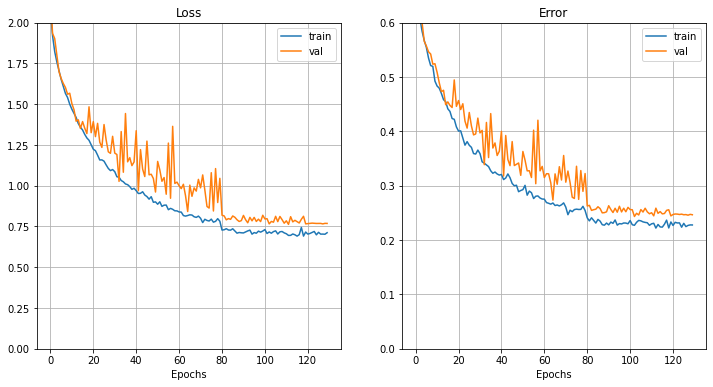

In [24]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_c0_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [25]:
history['val_acc'][-1]

0.7534000277519226

In [26]:
1 - history['val_acc'][-1]

0.2465999722480774

In [13]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=200)

input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel 

C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
#### Model with clipping to 0.5

In [14]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_c0_trainHistoryDict_clip_05', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/650
Learning rate:  0.001
100/100 [==============================] - 98s 839ms/step - loss: 5.8743 - acc: 0.1468 - val_loss: 4.6844 - val_acc: 0.1168

Epoch 00001: val_acc improved from -inf to 0.11680, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.001.h5


C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Epoch 2/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 2.2870 - acc: 0.1674 - val_loss: 2.3251 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.11680
Epoch 3/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 2.0071 - acc: 0.2330 - val_loss: 2.4962 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.11680
Epoch 4/650
Learning rate:  0.001
100/100 [==============================] - 80s 799ms/step - loss: 1.9404 - acc: 0.2458 - val_loss: 2.4592 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.11680
Epoch 5/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 1.8642 - acc: 0.2830 - val_loss: 2.3285 - val_acc: 0.1000

Epoch 00005: val_acc did not improve from 0.11680
Epoch 6/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.8434 - acc: 0.2817 - val_loss: 2.3497 - val_acc: 0.1105

Epoch

100/100 [==============================] - 78s 785ms/step - loss: 1.2308 - acc: 0.5557 - val_loss: 2.8802 - val_acc: 0.3038

Epoch 00037: val_acc did not improve from 0.47310
Epoch 38/650
Learning rate:  0.001
100/100 [==============================] - 78s 785ms/step - loss: 1.2372 - acc: 0.5607 - val_loss: 2.6118 - val_acc: 0.2775

Epoch 00038: val_acc did not improve from 0.47310
Epoch 39/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 1.1928 - acc: 0.5767 - val_loss: 1.9564 - val_acc: 0.4259

Epoch 00039: val_acc did not improve from 0.47310
Epoch 40/650
Learning rate:  0.001
100/100 [==============================] - 78s 785ms/step - loss: 1.1883 - acc: 0.5747 - val_loss: 1.3887 - val_acc: 0.5114

Epoch 00040: val_acc improved from 0.47310 to 0.51140, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.040.h5
Epoch 41/650
Learning rate:  0.001
100/100 [==============================] - 79s 793m


Epoch 00074: val_acc did not improve from 0.57520
Epoch 75/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 1.0753 - acc: 0.6161 - val_loss: 1.8336 - val_acc: 0.4178

Epoch 00075: val_acc did not improve from 0.57520
Epoch 76/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 1.0525 - acc: 0.6240 - val_loss: 4.4236 - val_acc: 0.2724

Epoch 00076: val_acc did not improve from 0.57520
Epoch 77/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 1.0761 - acc: 0.6144 - val_loss: 1.2839 - val_acc: 0.5483

Epoch 00077: val_acc did not improve from 0.57520
Epoch 78/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 1.0519 - acc: 0.6217 - val_loss: 1.7240 - val_acc: 0.4849

Epoch 00078: val_acc did not improve from 0.57520
Epoch 79/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 1.0536 -


Epoch 00113: val_acc did not improve from 0.57520
Epoch 114/650
Learning rate:  0.001
100/100 [==============================] - 78s 785ms/step - loss: 1.0009 - acc: 0.6373 - val_loss: 2.5346 - val_acc: 0.4472

Epoch 00114: val_acc did not improve from 0.57520
Epoch 115/650
Learning rate:  0.001
100/100 [==============================] - 78s 787ms/step - loss: 1.0087 - acc: 0.6405 - val_loss: 1.7176 - val_acc: 0.4994

Epoch 00115: val_acc did not improve from 0.57520
Epoch 116/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.9878 - acc: 0.6434 - val_loss: 5.0591 - val_acc: 0.2359

Epoch 00116: val_acc did not improve from 0.57520
Epoch 117/650
Learning rate:  0.001
100/100 [==============================] - 78s 786ms/step - loss: 0.9814 - acc: 0.6450 - val_loss: 3.1021 - val_acc: 0.2774

Epoch 00117: val_acc did not improve from 0.57520
Epoch 118/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.9

100/100 [==============================] - 79s 790ms/step - loss: 0.9488 - acc: 0.6612 - val_loss: 3.0394 - val_acc: 0.3512

Epoch 00152: val_acc did not improve from 0.58390
Epoch 153/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.9433 - acc: 0.6607 - val_loss: 2.2588 - val_acc: 0.4210

Epoch 00153: val_acc did not improve from 0.58390
Epoch 154/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.9585 - acc: 0.6559 - val_loss: 2.3138 - val_acc: 0.4217

Epoch 00154: val_acc did not improve from 0.58390
Epoch 155/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.9445 - acc: 0.6681 - val_loss: 4.7676 - val_acc: 0.2820

Epoch 00155: val_acc did not improve from 0.58390
Epoch 156/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.9429 - acc: 0.6633 - val_loss: 3.4833 - val_acc: 0.3130

Epoch 00156: val_acc did not im

Epoch 191/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.9155 - acc: 0.6765 - val_loss: 1.3750 - val_acc: 0.5398

Epoch 00191: val_acc did not improve from 0.58390
Epoch 192/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.9144 - acc: 0.6763 - val_loss: 2.0376 - val_acc: 0.4934

Epoch 00192: val_acc did not improve from 0.58390
Epoch 193/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.9253 - acc: 0.6704 - val_loss: 1.8100 - val_acc: 0.4143

Epoch 00193: val_acc did not improve from 0.58390
Epoch 194/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.9008 - acc: 0.6837 - val_loss: 8.7247 - val_acc: 0.1402

Epoch 00194: val_acc did not improve from 0.58390
Epoch 195/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.9095 - acc: 0.6792 - val_loss: 2.6981 - val_acc: 0.3

Epoch 230/650
Learning rate:  0.001
100/100 [==============================] - 78s 785ms/step - loss: 0.9030 - acc: 0.6863 - val_loss: 2.2061 - val_acc: 0.5481

Epoch 00230: val_acc did not improve from 0.58390
Epoch 231/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8978 - acc: 0.6824 - val_loss: 1.6552 - val_acc: 0.5646

Epoch 00231: val_acc did not improve from 0.58390
Epoch 232/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8942 - acc: 0.6865 - val_loss: 2.7358 - val_acc: 0.4105

Epoch 00232: val_acc did not improve from 0.58390
Epoch 233/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.9173 - acc: 0.6793 - val_loss: 3.3410 - val_acc: 0.2913

Epoch 00233: val_acc did not improve from 0.58390
Epoch 234/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8926 - acc: 0.6893 - val_loss: 7.1011 - val_acc: 0.1

100/100 [==============================] - 79s 796ms/step - loss: 0.8681 - acc: 0.6907 - val_loss: 2.3020 - val_acc: 0.4785

Epoch 00268: val_acc did not improve from 0.59650
Epoch 269/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8849 - acc: 0.6892 - val_loss: 4.1185 - val_acc: 0.3346

Epoch 00269: val_acc did not improve from 0.59650
Epoch 270/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8884 - acc: 0.6856 - val_loss: 1.6142 - val_acc: 0.5569

Epoch 00270: val_acc did not improve from 0.59650
Epoch 271/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.8869 - acc: 0.6881 - val_loss: 1.6902 - val_acc: 0.5136

Epoch 00271: val_acc did not improve from 0.59650
Epoch 272/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8703 - acc: 0.6931 - val_loss: 1.8908 - val_acc: 0.4847

Epoch 00272: val_acc did not im

100/100 [==============================] - 79s 793ms/step - loss: 0.8505 - acc: 0.7056 - val_loss: 2.1982 - val_acc: 0.4629

Epoch 00306: val_acc did not improve from 0.62090
Epoch 307/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8701 - acc: 0.6929 - val_loss: 3.3286 - val_acc: 0.3886

Epoch 00307: val_acc did not improve from 0.62090
Epoch 308/650
Learning rate:  0.001
100/100 [==============================] - 78s 786ms/step - loss: 0.8589 - acc: 0.6982 - val_loss: 5.7940 - val_acc: 0.2892

Epoch 00308: val_acc did not improve from 0.62090
Epoch 309/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8749 - acc: 0.6980 - val_loss: 4.1802 - val_acc: 0.2836

Epoch 00309: val_acc did not improve from 0.62090
Epoch 310/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8802 - acc: 0.6916 - val_loss: 2.9659 - val_acc: 0.3656

Epoch 00310: val_acc did not im

Epoch 345/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8611 - acc: 0.6973 - val_loss: 1.5072 - val_acc: 0.4894

Epoch 00345: val_acc did not improve from 0.62090
Epoch 346/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8438 - acc: 0.7058 - val_loss: 4.1107 - val_acc: 0.2392

Epoch 00346: val_acc did not improve from 0.62090
Epoch 347/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 0.8690 - acc: 0.6987 - val_loss: 2.8336 - val_acc: 0.3819

Epoch 00347: val_acc did not improve from 0.62090
Epoch 348/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.8658 - acc: 0.6958 - val_loss: 2.8120 - val_acc: 0.4238

Epoch 00348: val_acc did not improve from 0.62090
Epoch 349/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8519 - acc: 0.6985 - val_loss: 1.8984 - val_acc: 0.5

Epoch 384/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.8612 - acc: 0.6947 - val_loss: 2.1808 - val_acc: 0.4264

Epoch 00384: val_acc did not improve from 0.62090
Epoch 385/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.8571 - acc: 0.6989 - val_loss: 1.5648 - val_acc: 0.5761

Epoch 00385: val_acc did not improve from 0.62090
Epoch 386/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8595 - acc: 0.7038 - val_loss: 1.9011 - val_acc: 0.4563

Epoch 00386: val_acc did not improve from 0.62090
Epoch 387/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.8405 - acc: 0.7066 - val_loss: 4.5522 - val_acc: 0.2573

Epoch 00387: val_acc did not improve from 0.62090
Epoch 388/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.8334 - acc: 0.7058 - val_loss: 3.4681 - val_acc: 0.3


Epoch 00418: val_acc did not improve from 0.74680
Epoch 419/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.6451 - acc: 0.7733 - val_loss: 0.7946 - val_acc: 0.7226

Epoch 00419: val_acc did not improve from 0.74680
Epoch 420/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.6461 - acc: 0.7748 - val_loss: 0.7209 - val_acc: 0.7558

Epoch 00420: val_acc improved from 0.74680 to 0.75580, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.420.h5
Epoch 421/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.6563 - acc: 0.7686 - val_loss: 0.8791 - val_acc: 0.7124

Epoch 00421: val_acc did not improve from 0.75580
Epoch 422/650
Learning rate:  0.0001
100/100 [==============================] - 79s 795ms/step - loss: 0.6502 - acc: 0.7711 - val_loss: 0.7587 - val_acc: 0.7436

Epoch 00422: val_acc did not improve from 

100/100 [==============================] - 79s 790ms/step - loss: 0.6231 - acc: 0.7860 - val_loss: 0.9252 - val_acc: 0.7054

Epoch 00455: val_acc did not improve from 0.76740
Epoch 456/650
Learning rate:  0.0001
100/100 [==============================] - 79s 791ms/step - loss: 0.6400 - acc: 0.7729 - val_loss: 0.8068 - val_acc: 0.7163

Epoch 00456: val_acc did not improve from 0.76740
Epoch 457/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.6314 - acc: 0.7774 - val_loss: 0.7305 - val_acc: 0.7495

Epoch 00457: val_acc did not improve from 0.76740
Epoch 458/650
Learning rate:  0.0001
100/100 [==============================] - 79s 791ms/step - loss: 0.6111 - acc: 0.7860 - val_loss: 0.7939 - val_acc: 0.7320

Epoch 00458: val_acc did not improve from 0.76740
Epoch 459/650
Learning rate:  0.0001
100/100 [==============================] - 79s 794ms/step - loss: 0.6146 - acc: 0.7874 - val_loss: 0.7551 - val_acc: 0.7465

Epoch 00459: val_acc did no

Epoch 494/650
Learning rate:  0.0001
100/100 [==============================] - 80s 800ms/step - loss: 0.6287 - acc: 0.7813 - val_loss: 0.7071 - val_acc: 0.7529

Epoch 00494: val_acc did not improve from 0.76740
Epoch 495/650
Learning rate:  0.0001
100/100 [==============================] - 80s 808ms/step - loss: 0.6239 - acc: 0.7856 - val_loss: 0.8420 - val_acc: 0.7306

Epoch 00495: val_acc did not improve from 0.76740
Epoch 496/650
Learning rate:  0.0001
100/100 [==============================] - 80s 804ms/step - loss: 0.6229 - acc: 0.7803 - val_loss: 0.7119 - val_acc: 0.7546

Epoch 00496: val_acc did not improve from 0.76740
Epoch 497/650
Learning rate:  0.0001
100/100 [==============================] - 80s 806ms/step - loss: 0.6250 - acc: 0.7843 - val_loss: 0.8168 - val_acc: 0.7254

Epoch 00497: val_acc did not improve from 0.76740
Epoch 498/650
Learning rate:  0.0001
100/100 [==============================] - 80s 807ms/step - loss: 0.6246 - acc: 0.7865 - val_loss: 0.7675 - val_acc


Epoch 00532: val_acc did not improve from 0.76740
Epoch 533/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.6005 - acc: 0.7868 - val_loss: 0.7825 - val_acc: 0.7376

Epoch 00533: val_acc did not improve from 0.76740
Epoch 534/650
Learning rate:  0.0001
100/100 [==============================] - 79s 795ms/step - loss: 0.5999 - acc: 0.7944 - val_loss: 0.9183 - val_acc: 0.6934

Epoch 00534: val_acc did not improve from 0.76740
Epoch 535/650
Learning rate:  0.0001
100/100 [==============================] - 79s 794ms/step - loss: 0.5995 - acc: 0.7882 - val_loss: 1.2532 - val_acc: 0.6422

Epoch 00535: val_acc did not improve from 0.76740
Epoch 536/650
Learning rate:  0.0001
100/100 [==============================] - 79s 793ms/step - loss: 0.6049 - acc: 0.7867 - val_loss: 0.7733 - val_acc: 0.7299

Epoch 00536: val_acc did not improve from 0.76740
Epoch 537/650
Learning rate:  0.0001
100/100 [==============================] - 79s 791ms/step - loss

100/100 [==============================] - 79s 795ms/step - loss: 0.6005 - acc: 0.7889 - val_loss: 0.7980 - val_acc: 0.7312

Epoch 00571: val_acc did not improve from 0.76740
Epoch 572/650
Learning rate:  0.0001
100/100 [==============================] - 80s 799ms/step - loss: 0.6017 - acc: 0.7932 - val_loss: 0.6709 - val_acc: 0.7651

Epoch 00572: val_acc did not improve from 0.76740
Epoch 573/650
Learning rate:  0.0001
100/100 [==============================] - 79s 797ms/step - loss: 0.6007 - acc: 0.7919 - val_loss: 0.6745 - val_acc: 0.7651

Epoch 00573: val_acc did not improve from 0.76740
Epoch 574/650
Learning rate:  0.0001
100/100 [==============================] - 79s 793ms/step - loss: 0.6042 - acc: 0.7897 - val_loss: 0.7184 - val_acc: 0.7472

Epoch 00574: val_acc did not improve from 0.76740
Epoch 575/650
Learning rate:  0.0001
100/100 [==============================] - 79s 790ms/step - loss: 0.5947 - acc: 0.7930 - val_loss: 0.9052 - val_acc: 0.7036

Epoch 00575: val_acc did no

100/100 [==============================] - 79s 794ms/step - loss: 0.5898 - acc: 0.7938 - val_loss: 0.6549 - val_acc: 0.7746

Epoch 00608: val_acc did not improve from 0.77530
Epoch 609/650
Learning rate:  5e-07
100/100 [==============================] - 79s 792ms/step - loss: 0.5782 - acc: 0.8043 - val_loss: 0.6505 - val_acc: 0.7759

Epoch 00609: val_acc improved from 0.77530 to 0.77590, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.609.h5
Epoch 610/650
Learning rate:  5e-07
100/100 [==============================] - 79s 791ms/step - loss: 0.5857 - acc: 0.7973 - val_loss: 0.6492 - val_acc: 0.7756

Epoch 00610: val_acc did not improve from 0.77590
Epoch 611/650
Learning rate:  5e-07
100/100 [==============================] - 79s 792ms/step - loss: 0.5819 - acc: 0.7983 - val_loss: 0.6520 - val_acc: 0.7745

Epoch 00611: val_acc did not improve from 0.77590
Epoch 612/650
Learning rate:  5e-07
100/100 [==============================] - 79s 

Epoch 640/650
Learning rate:  5e-07
100/100 [==============================] - 79s 790ms/step - loss: 0.5697 - acc: 0.8024 - val_loss: 0.6361 - val_acc: 0.7811

Epoch 00640: val_acc did not improve from 0.78240
Epoch 641/650
Learning rate:  5e-07
100/100 [==============================] - 78s 788ms/step - loss: 0.5741 - acc: 0.7997 - val_loss: 0.6391 - val_acc: 0.7797

Epoch 00641: val_acc did not improve from 0.78240
Epoch 642/650
Learning rate:  5e-07
100/100 [==============================] - 79s 792ms/step - loss: 0.5676 - acc: 0.8008 - val_loss: 0.6359 - val_acc: 0.7813

Epoch 00642: val_acc did not improve from 0.78240
Epoch 643/650
Learning rate:  5e-07
100/100 [==============================] - 78s 785ms/step - loss: 0.5592 - acc: 0.8026 - val_loss: 0.6343 - val_acc: 0.7815

Epoch 00643: val_acc did not improve from 0.78240
Epoch 644/650
Learning rate:  5e-07
100/100 [==============================] - 79s 791ms/step - loss: 0.5686 - acc: 0.7989 - val_loss: 0.6393 - val_acc: 0.7

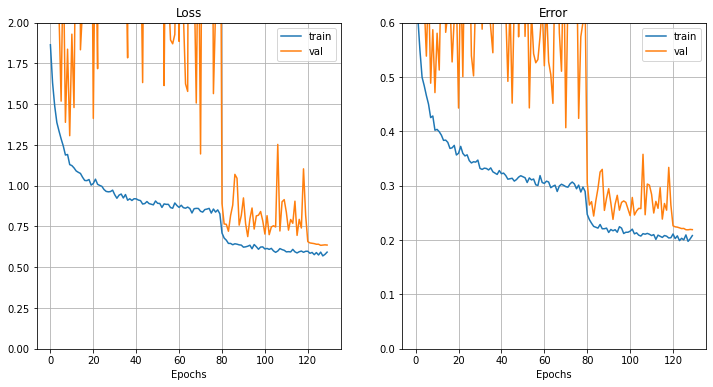

In [16]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_c0_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [17]:
history['val_acc'][-1]

0.7807999849319458

In [18]:
1 - history['val_acc'][-1]

0.2192000150680542

In [19]:
#### Model with clipping to 1

In [20]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_c0_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.8456 - acc: 0.7042 - val_loss: 5.1152 - val_acc: 0.2859

Epoch 00001: val_acc improved from -inf to 0.28590, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.001.h5


C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Epoch 2/650
Learning rate:  0.001
100/100 [==============================] - 78s 789ms/step - loss: 0.8067 - acc: 0.7224 - val_loss: 4.9626 - val_acc: 0.3909

Epoch 00002: val_acc improved from 0.28590 to 0.39090, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.002.h5
Epoch 3/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.7553 - acc: 0.7394 - val_loss: 1.8384 - val_acc: 0.5336

Epoch 00003: val_acc improved from 0.39090 to 0.53360, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.003.h5
Epoch 4/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.7501 - acc: 0.7420 - val_loss: 1.6188 - val_acc: 0.5157

Epoch 00004: val_acc did not improve from 0.53360
Epoch 5/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.7313 - acc: 0.7434 - val_loss: 2.1037 - val_acc: 0.53

100/100 [==============================] - 79s 793ms/step - loss: 0.7007 - acc: 0.7566 - val_loss: 1.5088 - val_acc: 0.5579

Epoch 00036: val_acc did not improve from 0.69560
Epoch 37/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.7057 - acc: 0.7552 - val_loss: 2.4539 - val_acc: 0.4757

Epoch 00037: val_acc did not improve from 0.69560
Epoch 38/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.7147 - acc: 0.7494 - val_loss: 1.4145 - val_acc: 0.6049

Epoch 00038: val_acc did not improve from 0.69560
Epoch 39/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 0.7081 - acc: 0.7549 - val_loss: 2.1139 - val_acc: 0.4836

Epoch 00039: val_acc did not improve from 0.69560
Epoch 40/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 0.7076 - acc: 0.7515 - val_loss: 1.5042 - val_acc: 0.5464

Epoch 00040: val_acc did not improv

100/100 [==============================] - 79s 795ms/step - loss: 0.6927 - acc: 0.7571 - val_loss: 1.8709 - val_acc: 0.5193

Epoch 00075: val_acc did not improve from 0.69560
Epoch 76/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 0.7058 - acc: 0.7544 - val_loss: 1.2170 - val_acc: 0.6348

Epoch 00076: val_acc did not improve from 0.69560
Epoch 77/650
Learning rate:  0.001
100/100 [==============================] - 78s 789ms/step - loss: 0.7056 - acc: 0.7538 - val_loss: 1.0448 - val_acc: 0.6568

Epoch 00077: val_acc did not improve from 0.69560
Epoch 78/650
Learning rate:  0.001
100/100 [==============================] - 79s 789ms/step - loss: 0.6852 - acc: 0.7639 - val_loss: 1.4102 - val_acc: 0.6112

Epoch 00078: val_acc did not improve from 0.69560
Epoch 79/650
Learning rate:  0.001
100/100 [==============================] - 79s 798ms/step - loss: 0.7060 - acc: 0.7517 - val_loss: 1.7446 - val_acc: 0.5891

Epoch 00079: val_acc did not improv

100/100 [==============================] - 79s 794ms/step - loss: 0.6991 - acc: 0.7573 - val_loss: 2.2736 - val_acc: 0.4831

Epoch 00114: val_acc did not improve from 0.69560
Epoch 115/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6958 - acc: 0.7554 - val_loss: 1.2777 - val_acc: 0.6059

Epoch 00115: val_acc did not improve from 0.69560
Epoch 116/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 0.7019 - acc: 0.7577 - val_loss: 1.4126 - val_acc: 0.5943

Epoch 00116: val_acc did not improve from 0.69560
Epoch 117/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.7072 - acc: 0.7530 - val_loss: 2.4168 - val_acc: 0.4934

Epoch 00117: val_acc did not improve from 0.69560
Epoch 118/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.6921 - acc: 0.7603 - val_loss: 1.1084 - val_acc: 0.6419

Epoch 00118: val_acc did not im

100/100 [==============================] - 79s 794ms/step - loss: 0.7022 - acc: 0.7544 - val_loss: 1.5855 - val_acc: 0.4547

Epoch 00152: val_acc did not improve from 0.69910
Epoch 153/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.7126 - acc: 0.7532 - val_loss: 1.2901 - val_acc: 0.6207

Epoch 00153: val_acc did not improve from 0.69910
Epoch 154/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.7075 - acc: 0.7569 - val_loss: 1.2916 - val_acc: 0.5858

Epoch 00154: val_acc did not improve from 0.69910
Epoch 155/650
Learning rate:  0.001
100/100 [==============================] - 79s 790ms/step - loss: 0.6813 - acc: 0.7658 - val_loss: 1.2872 - val_acc: 0.5749

Epoch 00155: val_acc did not improve from 0.69910
Epoch 156/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.7024 - acc: 0.7623 - val_loss: 1.3788 - val_acc: 0.5427

Epoch 00156: val_acc did not im

Epoch 191/650
Learning rate:  0.001
100/100 [==============================] - 78s 789ms/step - loss: 0.6773 - acc: 0.7646 - val_loss: 1.3951 - val_acc: 0.6053

Epoch 00191: val_acc did not improve from 0.69910
Epoch 192/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.7065 - acc: 0.7549 - val_loss: 1.9201 - val_acc: 0.5107

Epoch 00192: val_acc did not improve from 0.69910
Epoch 193/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.7052 - acc: 0.7544 - val_loss: 1.9156 - val_acc: 0.4455

Epoch 00193: val_acc did not improve from 0.69910
Epoch 194/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6964 - acc: 0.7580 - val_loss: 1.4743 - val_acc: 0.5441

Epoch 00194: val_acc did not improve from 0.69910
Epoch 195/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.6913 - acc: 0.7618 - val_loss: 1.7922 - val_acc: 0.5

100/100 [==============================] - 79s 791ms/step - loss: 0.6754 - acc: 0.7658 - val_loss: 2.4689 - val_acc: 0.5235

Epoch 00229: val_acc did not improve from 0.72220
Epoch 230/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6807 - acc: 0.7589 - val_loss: 1.2491 - val_acc: 0.5915

Epoch 00230: val_acc did not improve from 0.72220
Epoch 231/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.6810 - acc: 0.7615 - val_loss: 1.0121 - val_acc: 0.6403

Epoch 00231: val_acc did not improve from 0.72220
Epoch 232/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.6882 - acc: 0.7612 - val_loss: 3.0772 - val_acc: 0.4173

Epoch 00232: val_acc did not improve from 0.72220
Epoch 233/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.6765 - acc: 0.7632 - val_loss: 0.9452 - val_acc: 0.6777

Epoch 00233: val_acc did not im

Epoch 268/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.6638 - acc: 0.7670 - val_loss: 2.0427 - val_acc: 0.5050

Epoch 00268: val_acc did not improve from 0.72220
Epoch 269/650
Learning rate:  0.001
100/100 [==============================] - 79s 797ms/step - loss: 0.6605 - acc: 0.7682 - val_loss: 2.0018 - val_acc: 0.5752

Epoch 00269: val_acc did not improve from 0.72220
Epoch 270/650
Learning rate:  0.001
100/100 [==============================] - 79s 795ms/step - loss: 0.6896 - acc: 0.7549 - val_loss: 1.3268 - val_acc: 0.6182

Epoch 00270: val_acc did not improve from 0.72220
Epoch 271/650
Learning rate:  0.001
100/100 [==============================] - 79s 799ms/step - loss: 0.6738 - acc: 0.7673 - val_loss: 1.5236 - val_acc: 0.6014

Epoch 00271: val_acc did not improve from 0.72220
Epoch 272/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6881 - acc: 0.7629 - val_loss: 1.1632 - val_acc: 0.6

Epoch 307/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.6841 - acc: 0.7620 - val_loss: 1.5857 - val_acc: 0.5834

Epoch 00307: val_acc did not improve from 0.72220
Epoch 308/650
Learning rate:  0.001
100/100 [==============================] - 79s 798ms/step - loss: 0.6842 - acc: 0.7611 - val_loss: 2.0548 - val_acc: 0.4530

Epoch 00308: val_acc did not improve from 0.72220
Epoch 309/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6943 - acc: 0.7604 - val_loss: 1.3814 - val_acc: 0.5660

Epoch 00309: val_acc did not improve from 0.72220
Epoch 310/650
Learning rate:  0.001
100/100 [==============================] - 79s 798ms/step - loss: 0.6801 - acc: 0.7629 - val_loss: 1.0342 - val_acc: 0.6475

Epoch 00310: val_acc did not improve from 0.72220
Epoch 311/650
Learning rate:  0.001
100/100 [==============================] - 79s 794ms/step - loss: 0.6837 - acc: 0.7653 - val_loss: 1.1273 - val_acc: 0.6

Epoch 346/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.6837 - acc: 0.7653 - val_loss: 0.9443 - val_acc: 0.7007

Epoch 00346: val_acc did not improve from 0.72220
Epoch 347/650
Learning rate:  0.001
100/100 [==============================] - 80s 799ms/step - loss: 0.6699 - acc: 0.7627 - val_loss: 1.3699 - val_acc: 0.5993

Epoch 00347: val_acc did not improve from 0.72220
Epoch 348/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.6794 - acc: 0.7642 - val_loss: 1.0379 - val_acc: 0.6480

Epoch 00348: val_acc did not improve from 0.72220
Epoch 349/650
Learning rate:  0.001
100/100 [==============================] - 79s 793ms/step - loss: 0.6735 - acc: 0.7672 - val_loss: 2.2115 - val_acc: 0.5029

Epoch 00349: val_acc did not improve from 0.72220
Epoch 350/650
Learning rate:  0.001
100/100 [==============================] - 79s 792ms/step - loss: 0.6462 - acc: 0.7741 - val_loss: 1.2846 - val_acc: 0.5

Epoch 385/650
Learning rate:  0.001
100/100 [==============================] - 79s 791ms/step - loss: 0.6543 - acc: 0.7746 - val_loss: 1.5745 - val_acc: 0.6009

Epoch 00385: val_acc did not improve from 0.72220
Epoch 386/650
Learning rate:  0.001
100/100 [==============================] - 79s 796ms/step - loss: 0.6699 - acc: 0.7683 - val_loss: 2.1866 - val_acc: 0.5039

Epoch 00386: val_acc did not improve from 0.72220
Epoch 387/650
Learning rate:  0.001
100/100 [==============================] - 80s 804ms/step - loss: 0.6677 - acc: 0.7686 - val_loss: 1.5255 - val_acc: 0.5935

Epoch 00387: val_acc did not improve from 0.72220
Epoch 388/650
Learning rate:  0.001
100/100 [==============================] - 80s 799ms/step - loss: 0.6554 - acc: 0.7723 - val_loss: 1.3325 - val_acc: 0.6240

Epoch 00388: val_acc did not improve from 0.72220
Epoch 389/650
Learning rate:  0.001
100/100 [==============================] - 80s 803ms/step - loss: 0.6731 - acc: 0.7679 - val_loss: 3.7885 - val_acc: 0.3

100/100 [==============================] - 79s 793ms/step - loss: 0.5427 - acc: 0.8124 - val_loss: 0.6287 - val_acc: 0.7834

Epoch 00422: val_acc did not improve from 0.79440
Epoch 423/650
Learning rate:  0.0001
100/100 [==============================] - 79s 793ms/step - loss: 0.5332 - acc: 0.8160 - val_loss: 0.7045 - val_acc: 0.7651

Epoch 00423: val_acc did not improve from 0.79440
Epoch 424/650
Learning rate:  0.0001
100/100 [==============================] - 79s 794ms/step - loss: 0.5460 - acc: 0.8111 - val_loss: 0.7095 - val_acc: 0.7599

Epoch 00424: val_acc did not improve from 0.79440
Epoch 425/650
Learning rate:  0.0001
100/100 [==============================] - 79s 796ms/step - loss: 0.5439 - acc: 0.8140 - val_loss: 0.7704 - val_acc: 0.7498

Epoch 00425: val_acc did not improve from 0.79440
Epoch 426/650
Learning rate:  0.0001
100/100 [==============================] - 80s 799ms/step - loss: 0.5378 - acc: 0.8146 - val_loss: 0.6358 - val_acc: 0.7862

Epoch 00426: val_acc did no

Epoch 460/650
Learning rate:  0.0001
100/100 [==============================] - 79s 799ms/step - loss: 0.5086 - acc: 0.8237 - val_loss: 0.7633 - val_acc: 0.7537

Epoch 00460: val_acc did not improve from 0.80150
Epoch 461/650
Learning rate:  0.0001
100/100 [==============================] - 80s 801ms/step - loss: 0.5269 - acc: 0.8203 - val_loss: 0.7722 - val_acc: 0.7521

Epoch 00461: val_acc did not improve from 0.80150
Epoch 462/650
Learning rate:  0.0001
100/100 [==============================] - 80s 804ms/step - loss: 0.5287 - acc: 0.8127 - val_loss: 0.5803 - val_acc: 0.7995

Epoch 00462: val_acc did not improve from 0.80150
Epoch 463/650
Learning rate:  0.0001
100/100 [==============================] - 79s 799ms/step - loss: 0.5295 - acc: 0.8177 - val_loss: 0.7031 - val_acc: 0.7654

Epoch 00463: val_acc did not improve from 0.80150
Epoch 464/650
Learning rate:  0.0001
100/100 [==============================] - 79s 796ms/step - loss: 0.5297 - acc: 0.8184 - val_loss: 0.5931 - val_acc


Epoch 00498: val_acc did not improve from 0.80150
Epoch 499/650
Learning rate:  0.0001
100/100 [==============================] - 79s 791ms/step - loss: 0.5141 - acc: 0.8214 - val_loss: 0.6369 - val_acc: 0.7873

Epoch 00499: val_acc did not improve from 0.80150
Epoch 500/650
Learning rate:  0.0001
100/100 [==============================] - 79s 798ms/step - loss: 0.5153 - acc: 0.8180 - val_loss: 0.5900 - val_acc: 0.7966

Epoch 00500: val_acc did not improve from 0.80150
Epoch 501/650
Learning rate:  0.0001
100/100 [==============================] - 80s 801ms/step - loss: 0.5208 - acc: 0.8223 - val_loss: 0.6524 - val_acc: 0.7794

Epoch 00501: val_acc did not improve from 0.80150
Epoch 502/650
Learning rate:  0.0001
100/100 [==============================] - 80s 806ms/step - loss: 0.5230 - acc: 0.8184 - val_loss: 0.7656 - val_acc: 0.7583

Epoch 00502: val_acc did not improve from 0.80150
Epoch 503/650
Learning rate:  0.0001
100/100 [==============================] - 80s 800ms/step - loss

100/100 [==============================] - 80s 803ms/step - loss: 0.5110 - acc: 0.8237 - val_loss: 0.7527 - val_acc: 0.7584

Epoch 00537: val_acc did not improve from 0.80150
Epoch 538/650
Learning rate:  0.0001
100/100 [==============================] - 80s 802ms/step - loss: 0.5072 - acc: 0.8224 - val_loss: 0.6323 - val_acc: 0.7884

Epoch 00538: val_acc did not improve from 0.80150
Epoch 539/650
Learning rate:  0.0001
100/100 [==============================] - 79s 799ms/step - loss: 0.5179 - acc: 0.8209 - val_loss: 0.5877 - val_acc: 0.7984

Epoch 00539: val_acc did not improve from 0.80150
Epoch 540/650
Learning rate:  0.0001
100/100 [==============================] - 79s 797ms/step - loss: 0.5084 - acc: 0.8228 - val_loss: 0.7131 - val_acc: 0.7623

Epoch 00540: val_acc did not improve from 0.80150
Epoch 541/650
Learning rate:  0.0001
100/100 [==============================] - 80s 802ms/step - loss: 0.5061 - acc: 0.8268 - val_loss: 0.6719 - val_acc: 0.7712

Epoch 00541: val_acc did no

Epoch 576/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.5084 - acc: 0.8230 - val_loss: 0.8037 - val_acc: 0.7407

Epoch 00576: val_acc did not improve from 0.80150
Epoch 577/650
Learning rate:  0.0001
100/100 [==============================] - 79s 792ms/step - loss: 0.5112 - acc: 0.8210 - val_loss: 0.7401 - val_acc: 0.7645

Epoch 00577: val_acc did not improve from 0.80150
Epoch 578/650
Learning rate:  0.0001
100/100 [==============================] - 79s 794ms/step - loss: 0.4964 - acc: 0.8291 - val_loss: 0.5548 - val_acc: 0.8104

Epoch 00578: val_acc improved from 0.80150 to 0.81040, saving model to C:\Users\kateb\project21\SingularValues\CC\saved_models\cifar10_ResNet32v1_model.578.h5
Epoch 579/650
Learning rate:  0.0001
100/100 [==============================] - 79s 795ms/step - loss: 0.5116 - acc: 0.8242 - val_loss: 0.6207 - val_acc: 0.7881

Epoch 00579: val_acc did not improve from 0.81040
Epoch 580/650
Learning rate:  0.0001
100/10

100/100 [==============================] - 79s 790ms/step - loss: 0.5119 - acc: 0.8240 - val_loss: 0.5956 - val_acc: 0.8000

Epoch 00614: val_acc did not improve from 0.81040
Epoch 615/650
Learning rate:  5e-07
100/100 [==============================] - 78s 785ms/step - loss: 0.4987 - acc: 0.8286 - val_loss: 0.5941 - val_acc: 0.8008

Epoch 00615: val_acc did not improve from 0.81040
Epoch 616/650
Learning rate:  5e-07
100/100 [==============================] - 78s 785ms/step - loss: 0.5014 - acc: 0.8263 - val_loss: 0.5936 - val_acc: 0.8009

Epoch 00616: val_acc did not improve from 0.81040
Epoch 617/650
Learning rate:  5e-07
100/100 [==============================] - 78s 788ms/step - loss: 0.4924 - acc: 0.8250 - val_loss: 0.5938 - val_acc: 0.8007

Epoch 00617: val_acc did not improve from 0.81040
Epoch 618/650
Learning rate:  5e-07
100/100 [==============================] - 79s 790ms/step - loss: 0.4866 - acc: 0.8343 - val_loss: 0.5928 - val_acc: 0.8010

Epoch 00618: val_acc did not im

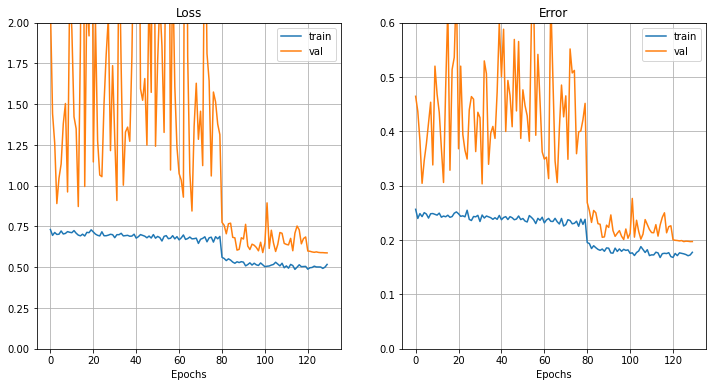

In [21]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_c0_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [22]:
history['val_acc'][-1]

0.8026999831199646

In [23]:
1 - history['val_acc'][-1]

0.1973000168800354

### n = 2

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=2)
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
circ_conv2d (CircConv2D)        (None, 32, 32, 16)   304         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          circ_conv2d[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_2_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=650)

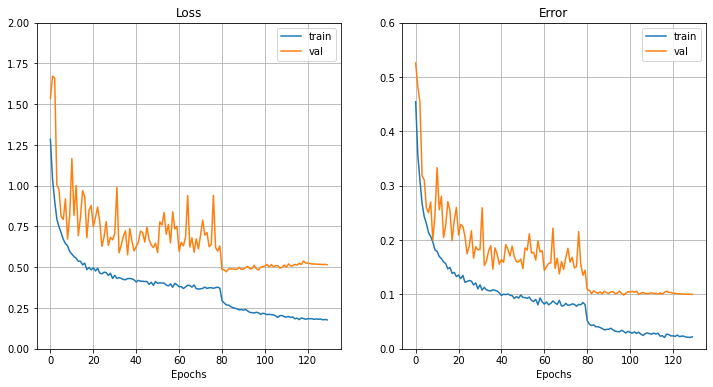

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_2_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8999000191688538

In [ ]:
1 - history['val_acc'][-1]

0.10009998083114624

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=2)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_2_trainHistoryDict_clip_05', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

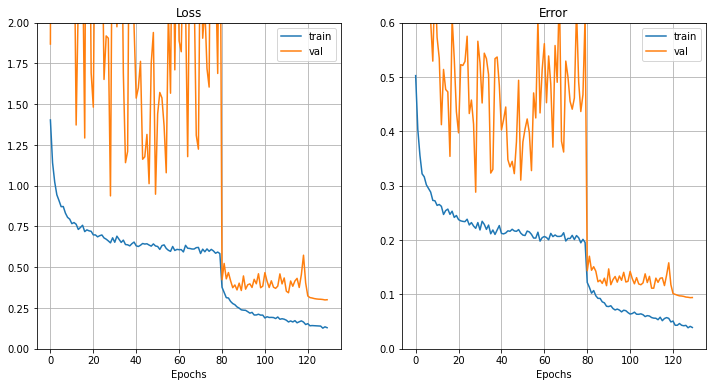

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_2_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.9057000279426575

In [ ]:
1 - history['val_acc'][-1]

0.09429997205734253

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=1)

In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_2_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

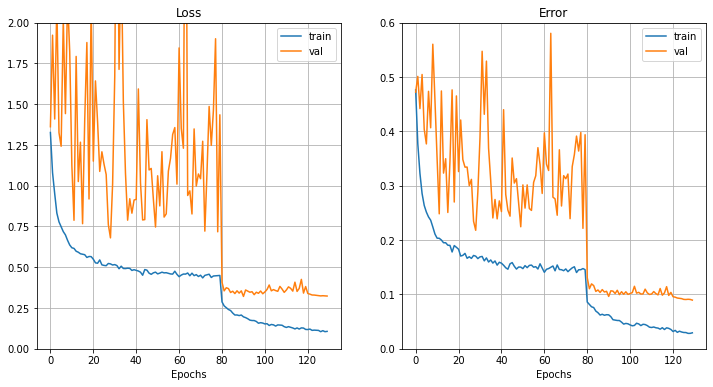

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_2_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.9103999733924866

In [ ]:
1 - history['val_acc'][-1]

0.08960002660751343

#### Plotting final graph

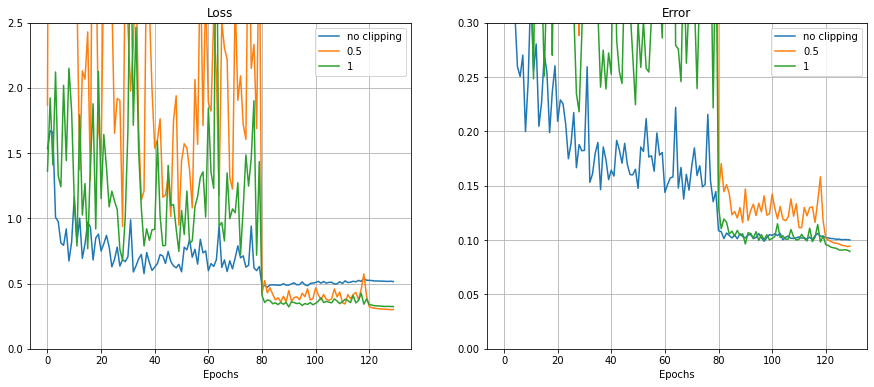

In [ ]:
plot_final_graph('n_2_', ylim_loss=2.5, ylim_error=0.3)

### n = 3

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=3)
model.summary()

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
circ_conv2d_33 (CircConv2D)     (None, 32, 32, 16)   178         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 32, 32, 16)   64          circ_conv2d_33[0][0]             
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batch_normalization_31[0][0]     
______________________________________________________________________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_3_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=650)

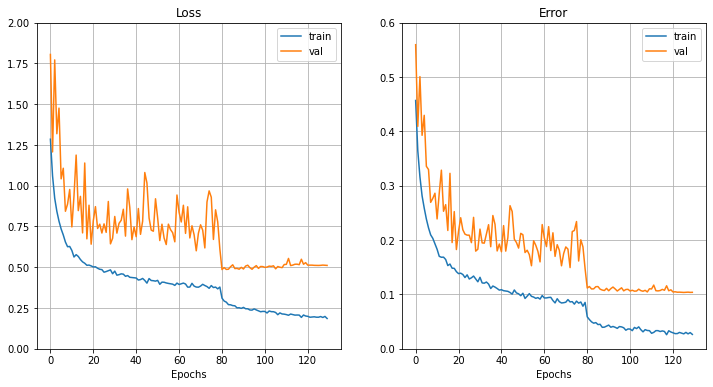

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_3_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8960999846458435

In [ ]:
1 - history['val_acc'][-1]

0.1039000153541565

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=3)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_3_trainHistoryDict_clip_05', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

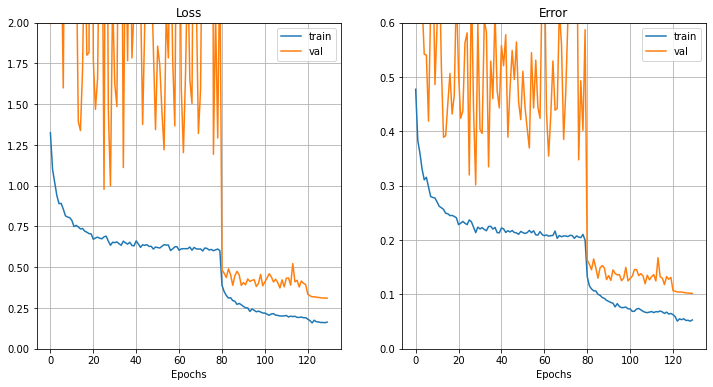

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_3_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8981999754905701

In [ ]:
1 - history['val_acc'][-1]

0.10180002450942993

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.ConvDecomposed2D, decomposition_rank=1)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_3_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

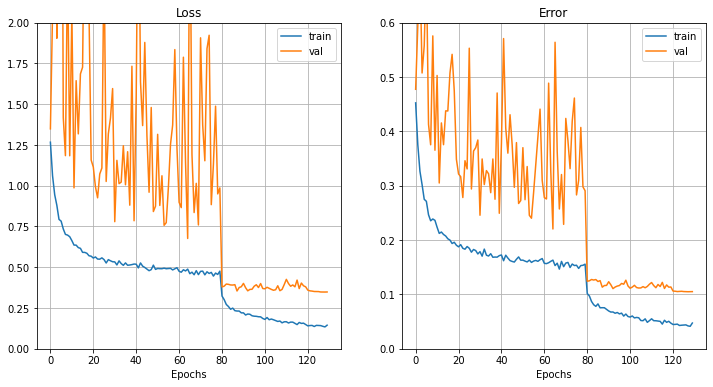

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_3_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8948000073432922

In [ ]:
1 - history['val_acc'][-1]

0.10519999265670776

#### Plotting final graph

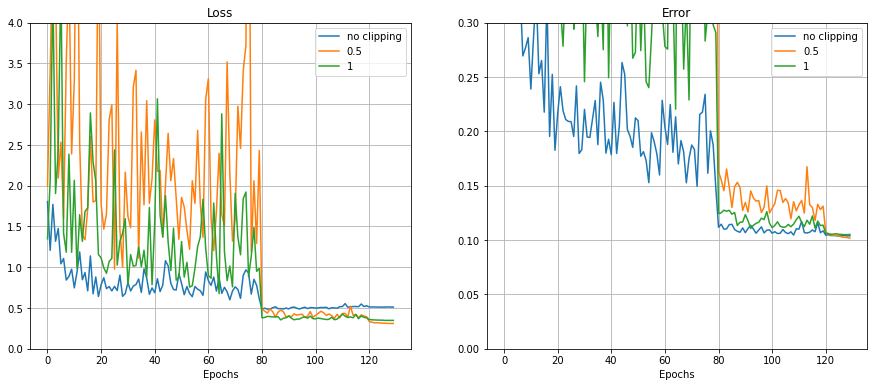

In [ ]:
plot_final_graph('n_3_', ylim_error=0.3)

### n = 5

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=5)
model.summary()

input_channel number is less than n, shrinking n forcibly
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
circ_conv2d (CircConv2D)        (None, 32, 32, 16)   178         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          circ_conv2d[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_5_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=650)

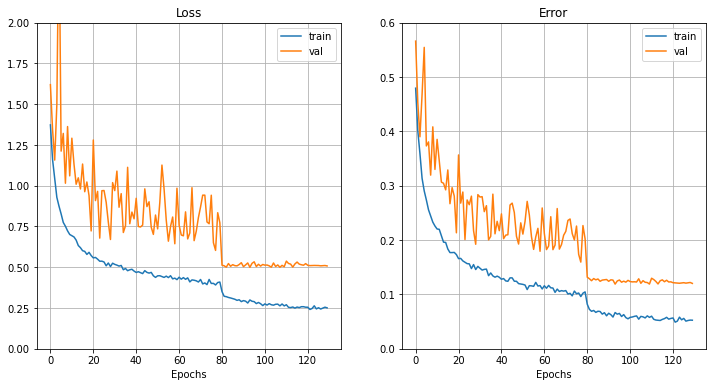

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_5_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8797000050544739

In [ ]:
1 - history['val_acc'][-1]

0.12029999494552612

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=5)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_5_trainHistoryDict_clip_05', steps_per_epoch=100,
                       batch_size=100, epochs=650,
                       callbacks=callbacks)

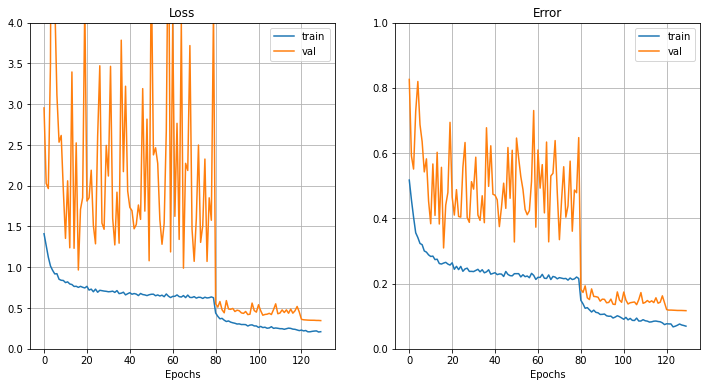

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_5_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 4, 1)

In [ ]:
history['val_acc'][-1]

0.8830999732017517

In [ ]:
1 - history['val_acc'][-1]

0.11690002679824829

#### Model with clipping to 1.0

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=5)

input_channel number is less than n, shrinking n forcibly
Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_5_trainHistoryDict_clip_1', steps_per_epoch=100,
                       batch_size=100, epochs=650,
                       callbacks=callbacks)

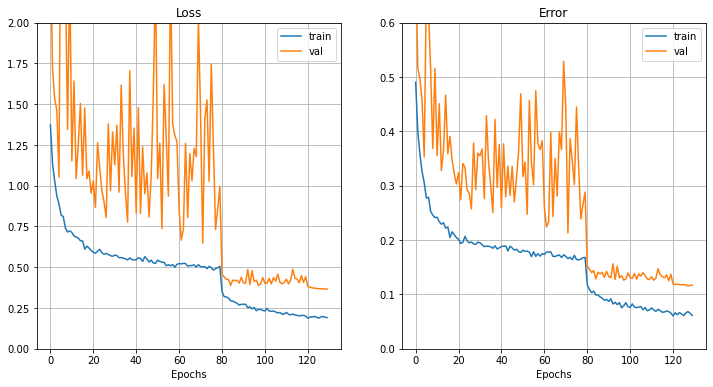

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_5_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8831999897956848

In [ ]:
1 - history['val_acc'][-1]

0.11680001020431519

#### Plotting final graph

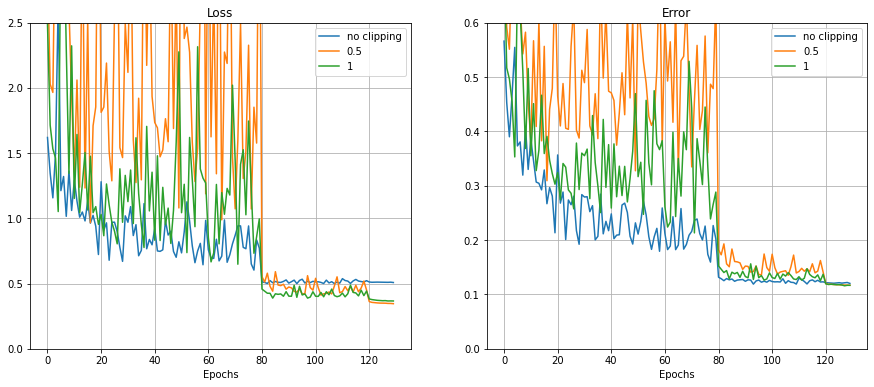

In [ ]:
plot_final_graph('n_5_', ylim_loss=2.5, ylim_error=0.6)

### n = 7

#### Model without clipping

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=7)
model.summary()

input_channel number is less than n, shrinking n forcibly
Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
circ_conv2d_66 (CircConv2D)     (None, 32, 32, 16)   178         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 32, 32, 16)   64          circ_conv2d_66[0][0]             
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 32, 32, 16)   0           batch_normalization_62[0][0]     
____________

In [ ]:
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_7_trainHistoryDict', steps_per_epoch=100, batch_size=100,
                       epochs=650)

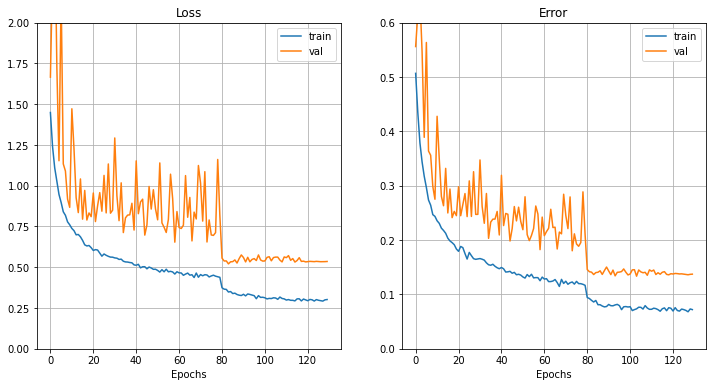

In [10]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_7_trainHistoryDict', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [11]:
history['val_acc'][-1]

0.8626999855041504

In [12]:
1 - history['val_acc'][-1]

0.1373000144958496

#### Model with clipping to 0.5

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=7)

Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(0.5)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_7_trainHistoryDict_clip_05', steps_per_epoch=100,
                       batch_size=100, epochs=650,
                       callbacks=callbacks)

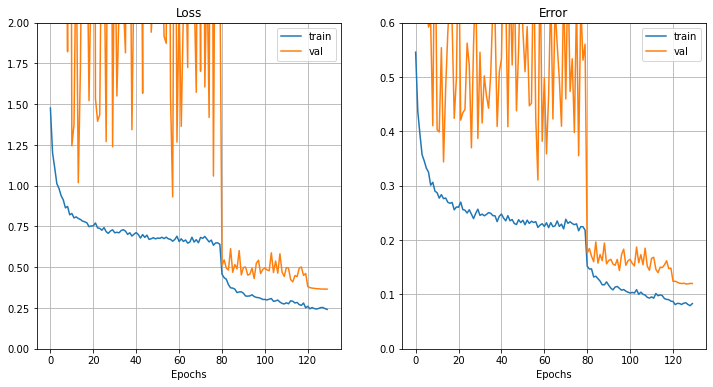

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_7_trainHistoryDict_clip_05', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.879800021648407

In [ ]:
1 - history['val_acc'][-1]

0.12019997835159302

#### Model with clipping to 1

In [ ]:
model, model_type = functions.define_and_compile_ResNet_model(
    input_shape, conv_layer = functions.CircConv2D, n=7)

input_channel number is less than n, shrinking n forcibly
Learning rate:  0.001


In [ ]:
callbacks = functions.standard_callbacks(model_type) + [functions.Clipping(1)]
history = functions.run_training(model, model_type, x_train, y_train, x_test, y_test,
                       'n_7_trainHistoryDict_clip_1', steps_per_epoch=100, epochs=650,
                       batch_size=100,
                       callbacks=callbacks)

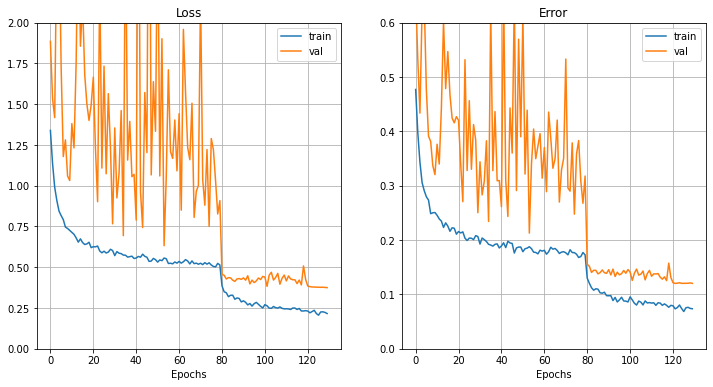

In [ ]:
import pickle
from matplotlib import pyplot as plt

history = pickle.load(open('n_7_trainHistoryDict_clip_1', "rb"))
functions.plot_loss_acc(history, 2, 0.6)

In [ ]:
history['val_acc'][-1]

0.8795999884605408

In [ ]:
1 - history['val_acc'][-1]

0.12040001153945923

#### Plotting_final_graph

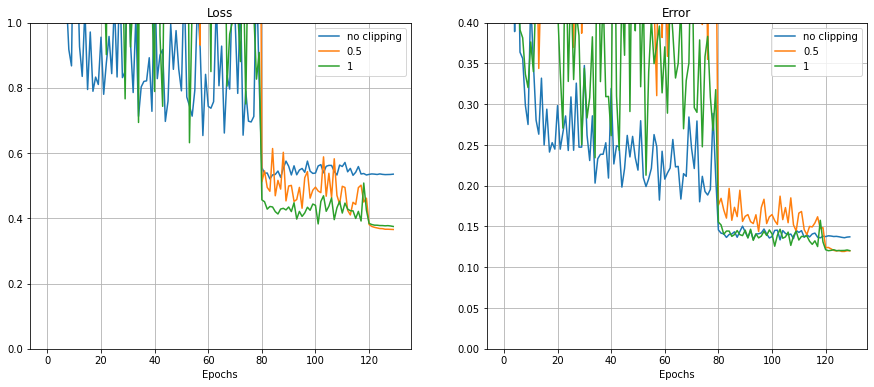

In [14]:
plot_final_graph("n_7_", ylim_loss=1, ylim_error=0.4)

### Plotting final graph

In [28]:
import pickle
number_of_params = []
best_val_err = [[], [], []]
best_val_loss = [[], [], []]
names_by_clip = ["", "_clip_05", "_clip_1"]
for i in (200, 7, 5, 3, 2):
    number_of_params.append(functions.define_and_compile_ResNet_model(
        input_shape, conv_layer = functions.CircConv2D, n=i)[0].count_params())
    for j in range(len(names_by_clip)):
        str_i = str(i)
        if i == 200:
            str_i = "c0"
        history = pickle.load(open('data/n_' + str_i + '_trainHistoryDict' + names_by_clip[j], "rb"))
        ind = np.argmax(history['val_acc'])
        best_val_loss[j].append(history['val_loss'][ind])
        best_val_err[j].append(1 - history['val_acc'][ind])
number_of_params.append(functions.define_and_compile_ResNet_model(input_shape)[0].count_params())
for j in range(len(names_by_clip)):
    history = pickle.load(open('data/simple_trainHistoryDict' + names_by_clip[j] + "_200_epochs", "rb"))
    ind = np.argmax(history['val_acc'])
    best_val_loss[j].append(history['val_loss'][ind])
    best_val_err[j].append(1 - history['val_acc'][ind])

input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
input_channel 

C:\Users\kateb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Learning rate:  0.001
input_channel number is less than n, shrinking n forcibly
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001


In [36]:
number_of_params_comp = number_of_params / np.max(number_of_params) * 100

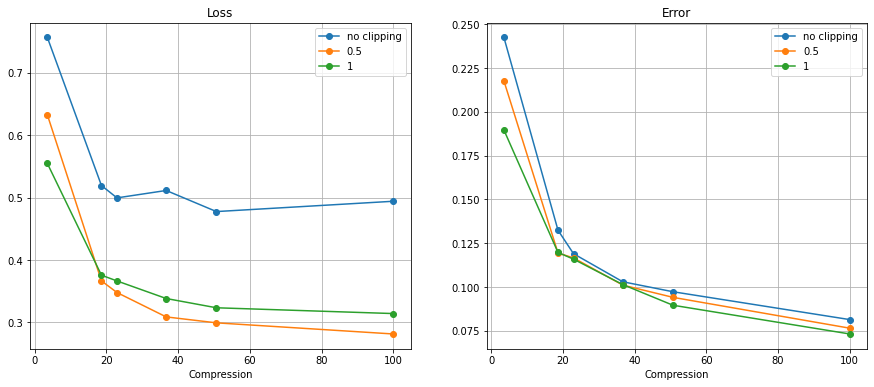

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].grid(True)
axs[1].grid(True)
axs[0].plot(number_of_params_comp, best_val_loss[0], 'o', linestyle='-', label='no clipping')
axs[0].plot(number_of_params_comp, best_val_loss[1], 'o', linestyle='-', label='0.5')
axs[0].plot(number_of_params_comp, best_val_loss[2], 'o', linestyle='-', label='1')
axs[0].set_title('Loss')
axs[0].set_xlabel('Compression')

axs[1].plot(number_of_params_comp, best_val_err[0], 'o', linestyle='-', label='no clipping')
axs[1].plot(number_of_params_comp, best_val_err[1], 'o', linestyle='-', label='0.5')
axs[1].plot(number_of_params_comp, best_val_err[2], 'o', linestyle='-', label='1')
axs[1].set_title('Error')
axs[1].set_xlabel('Compression')

axs[0].legend(loc='best')
_ = axs[1].legend(loc='best')

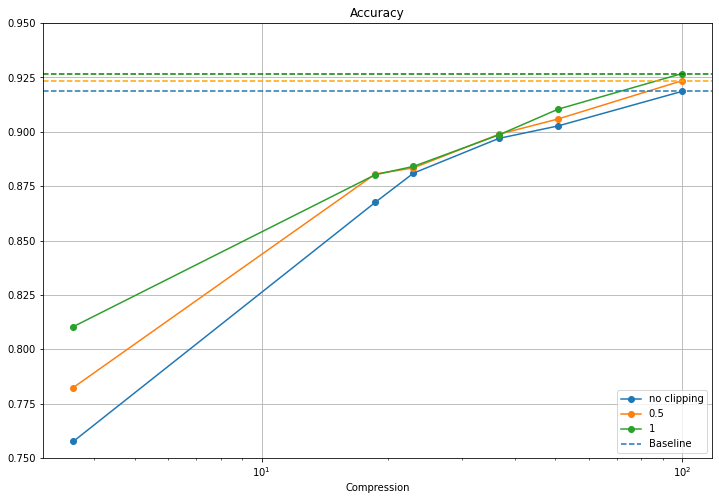

In [41]:
plt.figure(figsize=(12, 8))
plt.grid(True)

best_val_err = np.array(best_val_err)

plt.plot(number_of_params_comp, 1 - best_val_err[0], 'o', linestyle='-', label='no clipping')
plt.plot(number_of_params_comp, 1 - best_val_err[1], 'o', linestyle='-', label='0.5')
plt.plot(number_of_params_comp, 1 - best_val_err[2], 'o', linestyle='-', label='1')
plt.axhline(1 - best_val_err[0][-1], linestyle='--', label='Baseline')
plt.axhline(1 - best_val_err[1][-1], linestyle='--', c='orange')
plt.axhline(1 - best_val_err[2][-1], linestyle='--', c='green')
plt.title('Accuracy')
plt.xlabel('Compression')
plt.ylim(0.75, 0.95)
plt.xscale('log')
_ = plt.legend(loc='best')